Final Project 2021: Swearing and Dying in Quentin Tarantino Films: Is There a Logical Pattern?

This final project is building off of my homework 2, which focused on timestamps for Swearing + Deaths in Quentin Tarantino films. The goal of this project is to detect if there is any correlation between the amount of swearing in films and the amount of deaths. (i.e., do the films that have more swearing also have more deaths, or vice versa?) This program will use chi-squared testing as well as provide visualizations for as to how these variables change.

In [1]:
!pip install pathlib
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
!pip install seaborn
import seaborn as sns4
from scipy import stats

-------------------------------------------------------------------------------------------------------------------------------

It seems reasonable to assume that, given the nature of expletives and the blatant free use of them in Quentin Tarantino films, films that have a high proportion of deaths are going to also have a high proportion of swearing. This makes sense given the intense cultural, ethnic, and stylistic backgrounds that are featured in each of these films. 

So our hypothesis would be:

Quentin Tarantino films with high frequencies of swearing with subsequently have high frequencies of deaths.

First we are going to create our database for swearing and deaths. I primarily used DBeaver to interact with the database. The separate csv files will also be separate tables within the database so that we don't muddy the data and/or create confusion. The primary key here is "movie name," which will be used to refer to all of the separated tables. The tables that make up the Tarantino Database are "movies," "deaths," and "swears." 

f1: first table - organizing movie names: "Reservoir Dogs," "Pulp Fiction," "Kill Bill Vol. 1," "Kill Bill Vol. 2," "Django Unchained," "Inglorious Basterds," and "Jackie Brown."

In [2]:
with open('movies.csv', 'r', encoding = 'utf-8') as f1:
    f1 = f1.readlines()
    
conn = sqlite3.connect('tarantino.db')
c = conn.cursor()

c.execute("DROP TABLE IF EXISTS movies")
c.execute('''CREATE TABLE IF NOT EXISTS movies(
          movie_name TEXT, 
          CONSTRAINT movies_PK PRIMARY KEY(movie_name))''')

for row in f1:
    c.execute("INSERT INTO movies VALUES (?)", (row,))
    
conn.commit()

f2: second table - categorizing swears. Each movie is individually labeled with their movie_name, followed by a word (swear) and a timestamp for that word. Some of the swears include "fuck," "shit," "motherfucker(s)," and "fucking." 

In [3]:
with open('Swears.csv', 'r', encoding = 'utf-8') as f2:
    f2 = f2.readlines()
    
conn = sqlite3.connect('tarantino.db')
c = conn.cursor()

c.execute("DROP TABLE IF EXISTS swears")
c.execute('''CREATE TABLE IF NOT EXISTS swears(
          swear_id INTEGER PRIMARY KEY AUTOINCREMENT, 
          swear_timestamp NUMERIC,
          movie_name TEXT, 
          word TEXT, 
          CONSTRAINT swears_FK FOREIGN KEY (movie_name) REFERENCES movies(movie_name))''')

for row in f2:
    row = row.split(',')
    c.execute("INSERT INTO swears (movie_name, word, swear_timestamp) VALUES (?, ?, ?)", (row[0], row[1], row[2]))
    
conn.commit()

f3: third table - quantifying the amount of deaths in a movie. Each movie, like in f2, gets an individual label for movie_name, along with a timestamp.

In [4]:
with open('Deaths.csv', 'r', encoding = 'utf-8') as f3:
    f3 = f3.readlines()
    
conn = sqlite3.connect('tarantino.db')
c = conn.cursor()

c.execute("DROP TABLE IF EXISTS deaths")
c.execute('''CREATE TABLE IF NOT EXISTS deaths(
          death_id INTEGER PRIMARY KEY AUTOINCREMENT, 
          death_timestamp NUMERIC,
          movie_name TEXT, 
          CONSTRAINT deaths_FK FOREIGN KEY (movie_name) REFERENCES movies(movie_name))''')

for row in f3:
    row = row.split(',')
    c.execute("INSERT INTO deaths (movie_name, death_timestamp) VALUES (?, ?)", (row[0], row[1]))
    
conn.commit()

In [5]:
Path('tarantino.db').touch()

conn = sqlite3.connect('tarantino.db')
c = conn.cursor()

c.execute('''SELECT * FROM movies''')
print(c.fetchall())

[('Reservoir Dogs\n',), ('Pulp Fiction\n',), ('Kill Bill: Vol. 1\n',), ('Kill Bill: Vol. 2\n',), ('Inglorious Basterds\n',), ('Django Unchained\n',), ('Jackie Brown\n',)]


Creating dataframes from all three tables in the database, so that the data is easier to manipulate using pandas.

In [6]:
movies_df = pd.read_sql('''SELECT * FROM movies''', conn)
swears_df = pd.read_sql('''SELECT * FROM Swears''', conn)
deaths_df = pd.read_sql('''SELECT * FROM Deaths''', conn)

In [7]:
movies_df.insert(1, 'Year', [1992, 1994, 2003, 2004, 2009, 2012, 1997], True)
movies_df

,movie_name,Year
0,Reservoir Dogs\n,1992
1,Pulp Fiction\n,1994
2,Kill Bill: Vol. 1\n,2003
3,Kill Bill: Vol. 2\n,2004
4,Inglorious Basterds\n,2009
5,Django Unchained\n,2012
6,Jackie Brown\n,1997


In [8]:
movies_df = movies_df.sort_values(by='Year')
movies_df.insert(2, 'Runtime', ["99", "165", "154", "111", "137", "153", "165"], True)
movies_df

,movie_name,Year,Runtime
0,Reservoir Dogs\n,1992,99
1,Pulp Fiction\n,1994,165
6,Jackie Brown\n,1997,154
2,Kill Bill: Vol. 1\n,2003,111
3,Kill Bill: Vol. 2\n,2004,137
4,Inglorious Basterds\n,2009,153
5,Django Unchained\n,2012,165


In [9]:
swears_df

,swear_id,swear_timestamp,movie_name,word
0,1,0.40,Reservoir Dogs,dick
1,2,0.43,Reservoir Dogs,dicks
2,3,0.55,Reservoir Dogs,fucked
3,4,0.61,Reservoir Dogs,fucking
4,5,0.61,Reservoir Dogs,bullshit
...,...,...,...,...
1699,1700,141.80,Jackie Brown,motherfucker
1700,1701,141.93,Jackie Brown,motherfucker
1701,1702,142.43,Jackie Brown,ass
1702,1703,142.47,Jackie Brown,fucking


In [10]:
deaths_df

,death_id,death_timestamp,movie_name
0,1,59.93,Reservoir Dogs
1,2,85.58,Reservoir Dogs
2,3,85.58,Reservoir Dogs
3,4,85.81,Reservoir Dogs
4,5,86.55,Reservoir Dogs
...,...,...,...
185,186,160.45,Django Unchained
186,187,23.08,Jackie Brown
187,188,113.28,Jackie Brown
188,189,125.43,Jackie Brown


Top 10 swear words across Quentin Tarantino movies (this is mostly just out of curiosity):

In [11]:
n = 10
swears_df['word'].value_counts()[:n].index.tolist()

['fucking',
 'shit',
 'fuck',
 'n-word',
 'ass',
 'goddamn',
 'motherfucker',
 'bitch',
 'hell',
 'damn']

Organized dataframe of Tarantino movies and swear words used in them, from highest frequency to lowest (and in descending alphabetical order):

In [12]:
org_swears_df = swears_df.sort_values(by='word').groupby(['movie_name', 'word']).size().reset_index(name='count')
list_swears_df = org_swears_df.sort_values(['movie_name','count'], ascending=False).groupby('word').head(3)
list_swears_df

,movie_name,word,count
146,Reservoir Dogs,fucking,180
143,Reservoir Dogs,fuck,68
156,Reservoir Dogs,shit,45
128,Reservoir Dogs,ass,13
140,Reservoir Dogs,dick,13
...,...,...,...
30,Inglorious Basterds,slut,1
31,Inglorious Basterds,squaw,1
11,Django Unchained,horseshit,2
9,Django Unchained,goddamned,1


Total count of instances of swears per movie: 

In [13]:
unorg_swears_df = swears_df.groupby(['movie_name']).size().reset_index(name='count')
unorg_swears_df

,movie_name,count
0,Django Unchained,262
1,Inglorious Basterds,58
2,Jackie Brown,368
3,Kill Bill: Vol. 1,57
4,Kill Bill: Vol. 2,69
5,Pulp Fiction,469
6,Reservoir Dogs,421


Ordered total count of instances of swears per movie (from highest to lowest):

In [14]:
org_swears_df = swears_df.groupby(['movie_name']).size().reset_index(name='count')
count_swears_df = org_swears_df.sort_values(by='count', ascending=False)
count_swears_df

,movie_name,count
5,Pulp Fiction,469
6,Reservoir Dogs,421
2,Jackie Brown,368
0,Django Unchained,262
4,Kill Bill: Vol. 2,69
1,Inglorious Basterds,58
3,Kill Bill: Vol. 1,57


Total count of instances of deaths per movie:

In [15]:
unorg_deaths_df = deaths_df.groupby(['movie_name']).size().reset_index(name='count')
unorg_deaths_df

,movie_name,count
0,Django Unchained,47
1,Inglorious Basterds,48
2,Jackie Brown,4
3,Kill Bill: Vol. 1,63
4,Kill Bill: Vol. 2,11
5,Pulp Fiction,7
6,Reservoir Dogs,10


Ordered total count of instances of deaths per movie (from highest to lowest):

In [16]:
org_deaths_df = deaths_df.groupby(['movie_name']).size().reset_index(name='count')
count_deaths_df = org_deaths_df.sort_values(by='count', ascending=False)
count_deaths_df

,movie_name,count
3,Kill Bill: Vol. 1,63
1,Inglorious Basterds,48
0,Django Unchained,47
4,Kill Bill: Vol. 2,11
6,Reservoir Dogs,10
5,Pulp Fiction,7
2,Jackie Brown,4


Contingency table for words used and their instances per movie:

In [21]:
crosstab = pd.crosstab(swears_df['word'], swears_df['movie_name'])
crosstab

movie_name,Django Unchained,Inglorious Basterds,Jackie Brown,Kill Bill: Vol. 1,Kill Bill: Vol. 2,Pulp Fiction,Reservoir Dogs
word,,,,,,,
ass,28,6,52,3,7,31,13
asses,0,0,0,0,0,3,1
asshead,0,0,0,0,0,0,1
asshole,0,0,0,0,1,3,6
assholes,0,0,0,0,1,1,3
bastard,1,0,0,2,2,0,5
bastards,0,0,0,0,1,0,0
bitch,10,1,13,7,6,15,12
bitches,5,1,1,1,0,0,1


Statistical analysis of the swearing dataframe. It appears that, if the film is a Tarantino film, then it's likely going to have a high proportion of swearing :)

In [22]:
stats.chi2_contingency(crosstab)

(1519.0553948313238,
 8.605866893655085e-144,
 354,
 array([[2.15258216e+01, 4.76525822e+00, 3.02347418e+01, 4.68309859e+00,
         5.66901408e+00, 3.85328638e+01, 3.45892019e+01],
        [6.15023474e-01, 1.36150235e-01, 8.63849765e-01, 1.33802817e-01,
         1.61971831e-01, 1.10093897e+00, 9.88262911e-01],
        [1.53755869e-01, 3.40375587e-02, 2.15962441e-01, 3.34507042e-02,
         4.04929577e-02, 2.75234742e-01, 2.47065728e-01],
        [1.53755869e+00, 3.40375587e-01, 2.15962441e+00, 3.34507042e-01,
         4.04929577e-01, 2.75234742e+00, 2.47065728e+00],
        [7.68779343e-01, 1.70187793e-01, 1.07981221e+00, 1.67253521e-01,
         2.02464789e-01, 1.37617371e+00, 1.23532864e+00],
        [1.53755869e+00, 3.40375587e-01, 2.15962441e+00, 3.34507042e-01,
         4.04929577e-01, 2.75234742e+00, 2.47065728e+00],
        [1.53755869e-01, 3.40375587e-02, 2.15962441e-01, 3.34507042e-02,
         4.04929577e-02, 2.75234742e-01, 2.47065728e-01],
        [9.84037559e+00, 2.1784

Joining the two dataframes for both Swears and Deaths, where count_x = death total and count_y = swear total per movie:

In [30]:
total_df = unorg_deaths_df.merge(unorg_swears_df, on='movie_name', how='left')
total_df

,movie_name,count_x,count_y
0,Django Unchained,47,262
1,Inglorious Basterds,48,58
2,Jackie Brown,4,368
3,Kill Bill: Vol. 1,63,57
4,Kill Bill: Vol. 2,11,69
5,Pulp Fiction,7,469
6,Reservoir Dogs,10,421


Pearson's Correlation on the two columns of data, to see if there is a relationship between the amount of deaths and the amount of swearing in Quentin Tarantino movies:

In [31]:
total_df.corr(method='pearson')

,count_x,count_y
count_x,1.00000,-0.66741
count_y,-0.66741,1.00000


Figure 1: overlapping bar charts for swearing and death counts in each movie

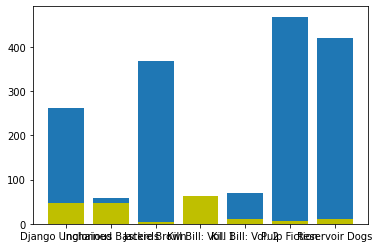

In [17]:
X = unorg_swears_df['movie_name']
Y = unorg_swears_df['count']
X2 = unorg_swears_df['movie_name']
Y2 = unorg_deaths_df['count']

plt.bar(X, Y)
plt.bar(X2, Y2, color='y')
plt.show()

Figure 2: Swearing for each movie (count)

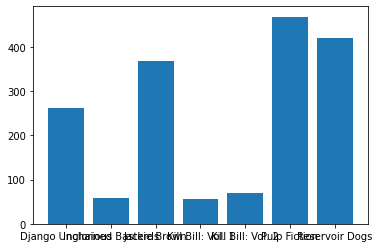

In [18]:
X = unorg_swears_df['movie_name']
Y = unorg_swears_df['count']
plt.bar(X, Y)
plt.show()

Figure 3: Deaths for each movie (count)

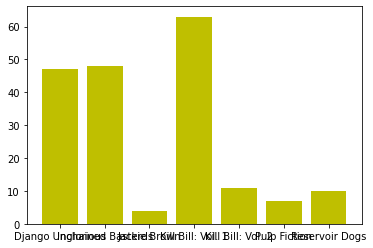

In [19]:
X2 = unorg_deaths_df['movie_name']
Y2 = unorg_deaths_df['count']

plt.bar(X2, Y2, color='y')
plt.show()

Figure 4: Line plot representing the amount of swears in each movie (from greatest to least), along with the corresponding amount of deaths in each of those movies.

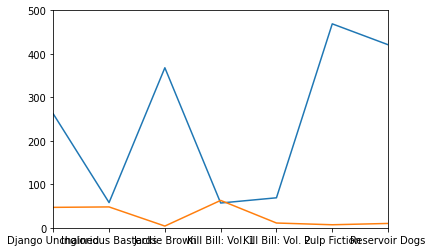

In [20]:
fig = plt.figure()

for frame in [unorg_swears_df, unorg_deaths_df]:
    plt.plot(frame['movie_name'], frame['count'])

plt.xlim(0,6)
plt.ylim(0,500)
plt.show()

Conclusion: It appears that, based on these results, there is not much correlation between the amount of swears and the amount of deaths in Quentin Tarantino movies. As a matter of fact, it seems that there appears to be a drastic difference between the amount of deaths and the amount of swears. Based on the Pearson's correlation, which provided us with a value of -0.67, and the visualizations that are presented above, which show us that if there was a high proportion of swearing in a film, there tends to be a low proportion of deaths. And in a couple outliers, it doesn't even seem to make much of a difference. This would be interesting to pursue for future research projects, given that the colorful usage of expletives is becoming more and more colorful throughout the years. Quentin Tarantino movies are likely going to have a fair amount of swearing, but what about other films within the same genre(s) by other directors? What about in general? Do films in general have a high propensity to include swearing when there are a lot of deaths? These are some questions I've come up with throughout the course of completing this project.

P.S. Jokes! I think it would also be interesting to include a new variable, like jokes! For the future, it would be interesting to consider at which timestamps do these variables occur. For example, if we have a timestamp for a death in the movie, do we see a spike in jokes or swearing around this occurrence? And does it even make a difference if we have them or not?